# Data Integration

The integration script is for reference only and the integrated dataframe can be downloaded with the link: %

In [1]:
# import os, re, sys
# import fcsparser
# import pandas as pd

# sys.path.insert(0, "../..")
# from scripts.aux_functions import *


In [2]:
# Import raw data
# base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/Figure6-S6/Signal Perturbation"
# os.makedirs(f"{base_dir}/output", exist_ok=True)
# input_dir = f"{base_dir}/preprocessed_data"
# output_dir = f"{base_dir}/output"

# filelist = [f for f in os.listdir(input_dir) if f.endswith(".txt")]
# filelist


In [3]:
# ---
# Integration
# ---

# Naming convention:
# batch_experiment_genotype_barcode_ligand-inhibitor_replicate
# e.g. "B1_Perturb_WT_001_Ctrl-Ctrl_1.txt"

# integrated = pd.DataFrame()
# for f in filelist:
#     df_new = pd.read_csv(f"{input_dir}/{f}", sep="\t")

#     batch = f.split("_")[0]
#     barcode = f.split("_")[3]
#     genotype = f.split("_")[2]
#     media = f.split("_")[4]
#     replicate = f.split("_")[-1].split(".")[0]

#     df_new["batch"] = batch
#     df_new["barcode"] = barcode
#     df_new["genotype"] = genotype
#     df_new["media"] = media
#     df_new["replicate"] = replicate
#     df_new["culture"] = genotype + "_" + media
#     df_new["condition"] = batch + "_" + genotype + "_" + media + "_" + replicate
#     df_new["ligand"] = media.split("-")[0]
#     df_new["inhibitor"] = media.split("-")[1]

#     # break down genotype
#     df_new["A"] = 1 if "A" in genotype else 0
#     df_new["K"] = 1 if "K" in genotype else 0

#     integrated = pd.concat([integrated, df_new])
# integrated.head()
# integrated.shape

# # integrated = rename_panel(integrated)  # Revome the version number etc.
# integrated = integrated.rename(
#     columns=lambda x: re.sub("_v[0-9]+$", "", x)
# )  # Revome the version number
# integrated.columns.values
# integrated.to_csv(f"{output_dir}/integrated_dataframe_all-cells.csv", index=False)


# EMD Calculation

In [1]:
import os, sys
import pandas as pd
import scprep
from scipy.stats import zscore

sys.path.insert(0, "../..")
from scripts.aux_functions import *
from scripts.__init__ import non_marker


In [2]:
# Import data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/Figure6-S6/Signal Perturbation"
os.makedirs(f"{base_dir}/output/emd", exist_ok=True)
output_dir = f"{base_dir}/output/emd"

# NB: integrated dataframe can be accessed at <10.5281/zenodo.7586958>
input_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Data Share/CyTOFdataframes"

In [3]:
# Generate full_panel and metadata_columns on the fly
df = pd.read_csv(f"{input_dir}/Signal-Perturbation_all-cells.csv")
df_columns = df.columns.values.tolist()
column_filtered = list(
    filter(lambda x: x not in non_marker, df_columns)
)  # Exclude non-markers

full_panel = [i for i in column_filtered if i[0].isdigit()]
metadata_columns = list(filter(lambda x: x not in full_panel, column_filtered))


In [4]:
# EMD calculation

df_arc = arcsinh_transf(df, full_panel, 5) # Arcsinh transformation
emd_ref = df_arc.loc[df_arc["culture"] == "WT_Ctrl-Ctrl"]  #! Set reference for EMD calculation
emd_ref.shape

emd_df = pd.DataFrame()
emd_df_master = pd.DataFrame()
emd_infodict = {}

# Get all experimental conditions for which EMD is going to be calculated
conditions = df_arc["condition"].unique().tolist()
len(conditions) # 360

# Compute EMD and compile the result in a master dataframe
for condition in conditions:
    compare_from = df_arc.loc[df_arc["condition"] == condition]
    df = calculate_emd(
        full_panel,  # all antibody measurements
        compare_from,
        emd_ref,
        metadata_columns,
        emd_df,
        emd_infodict,
    )
    emd_df_master = pd.concat([emd_df_master, df])
emd_df_master.head()

# Long to wide transformation
emd_df_master_wide = emd_df_master.pivot_table(
    index=metadata_columns,
    columns="marker",
    values="EMD_arc",
).reset_index()

emd_df_master_wide.head()
emd_df_master_wide.to_csv(
    f"{output_dir}/emd_df_master_all-cells_no-norm.csv",
    index=False,
)

## EMD-PHATE Overview (Figure 6B-E)

In [6]:
import os, sys
import pandas as pd
import numpy as np
import phate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, "../..")
from scripts.aux_functions import *
from scripts import colours

from IPython.core.interactiveshell import InteractiveShell
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
# Import data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/Figure6_S6/Signal Perturbation"
input_dir = f"{base_dir}/output/emd"
output_dir = f"{base_dir}/output/"

# Set experimental metadata
subset = "all-cells"
norm = "no-norm" # no-norm
seed = 42
knn = 8
t = 10

dr_panel = [
     # cell-type
    "111Cd_CD44",
    # "113In_CEACAM1_CD66a",
    # "115In_Pan-CK",
    # "116Cd_GFP",
    "143Nd_C-MYC_1",
    "162Dy_LRIG1_1",
    "169Tm_EPHB2",
    "171Yb_SOX9_5",
    "174Yb_Clusterin_1",
    "175Lu_Survivin_2",
    "176Yb_FABP2",
]

# Import data and get ready for PHATE
emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_{subset}_{norm}.csv")
dr_matrix = master_df_subset(emd_df_master_wide, dr_panel)

<IPython.core.display.Javascript object>

## PHATE

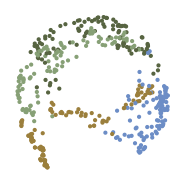

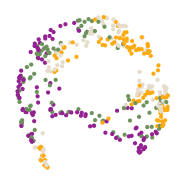

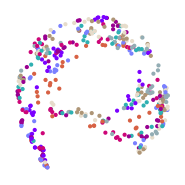

<IPython.core.display.Javascript object>

In [3]:
phate_operator = phate.PHATE(
    knn=knn, t=t, random_state=seed, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide = emd_df_master_wide.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide.drop(columns="index", inplace=True)

# ---
# Export
# ---

# Adjust the plotting order
Y_phate_df_wt_ctrl = Y_phate_df.loc[(Y_phate_df["culture"] == "WT_Ctrl-Ctrl")]
Y_phate_df_ak_ctrl = Y_phate_df.loc[Y_phate_df["culture"] == "AK_Ctrl-Ctrl"]
Y_phate_df_other = Y_phate_df.loc[-Y_phate_df["culture"].isin(["AK_Ctrl-Ctrl", "WT_Ctrl-Ctrl"])]
Y_phate_df = pd.concat([Y_phate_df_other, Y_phate_df_ak_ctrl, Y_phate_df_wt_ctrl])

facets = ["genotype", "ligand", "inhibitor"]
for facet in facets:
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, facet],
        cmap=colours,
        ticks=False,
        s=4,
        label=None,
        legend=False,
        figsize=(2.2, 2.2),
    )
    fig.axis("off")

### CLU, LRIG1, Pan-CK, and SURVIVIN [S801/811]

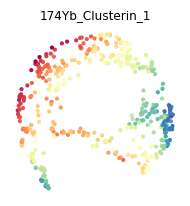

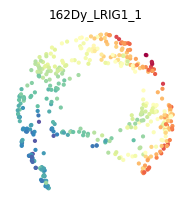

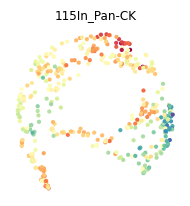

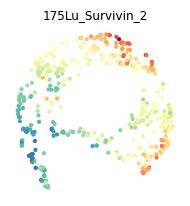

<IPython.core.display.Javascript object>

In [4]:
for marker in ["174Yb_Clusterin_1",  "162Dy_LRIG1_1", "115In_Pan-CK","175Lu_Survivin_2"]:
    fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.2))
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, marker],
        cmap=sns.color_palette("Spectral_r", as_cmap=True),
        ticks=False,
        s=4,
        xlabel="",
        ylabel="",
        legend=False,
        title=marker,
        fontsize=5,
        ax=ax,
    )
    fig.axis("off")
    # plt.savefig(
    #     f"{output_dir}/EMD-PHATE_WNT-EGF-Gradient_{marker}.pdf",
    #     bbox_inches="tight",
    #     )


## PCA

In [7]:
# ---
# PCA
# ---

pca = PCA(n_components=2)
pca.fit(dr_matrix)

Y_pca = pca.transform(dr_matrix)
pc1 = round(pca.explained_variance_ratio_[0] * 100, 2)  # %variance explained
pc2 = round(pca.explained_variance_ratio_[1] * 100, 2)

# Join PCA coordinates with EMD dataframe
Y_pca_df = pd.DataFrame(Y_pca).reset_index()
emd_df_master_wide = emd_df_master_wide.reset_index(drop=True).reset_index()
Y_pca_df = pd.merge(emd_df_master_wide, Y_pca_df, on="index")
Y_pca_df.drop(columns=["index"], inplace=True)
emd_df_master_wide.drop(columns="index", inplace=True)
Y_pca_df.head()

,batch,barcode,genotype,media,replicate,culture,condition,ligand,inhibitor,A,...,174Yb_Clusterin_1,175Lu_Survivin_2,176Yb_FABP2,191Ir_DNA 1,193Ir_DNA 2,194Pt_Cisplatin,209Bi_DiMeHH3_K4,89Y_pHH3_S28,0,1
0,B1,1,A,Ctrl-Ctrl,1,A_Ctrl-Ctrl,B1_A_Ctrl-Ctrl_1,Ctrl,Ctrl,1,...,-0.298011,0.271858,-0.361834,-0.231218,-0.231575,-0.256606,0.504046,0.096843,0.807593,-0.490783
1,B1,1,AK,Ctrl-Ctrl,1,AK_Ctrl-Ctrl,B1_AK_Ctrl-Ctrl_1,Ctrl,Ctrl,1,...,-1.435752,-0.092855,-1.041622,-0.875199,-0.873911,-0.564966,-0.775118,-0.292336,1.437778,0.879294
2,B1,1,K,Ctrl-Ctrl,1,K_Ctrl-Ctrl,B1_K_Ctrl-Ctrl_1,Ctrl,Ctrl,0,...,-0.948054,-0.203319,-0.872706,-0.317606,-0.315785,-0.266296,-0.329407,-0.290568,0.094124,0.787775
3,B1,1,WT,Ctrl-Ctrl,1,WT_Ctrl-Ctrl,B1_WT_Ctrl-Ctrl_1,Ctrl,Ctrl,0,...,0.035177,0.007109,0.101185,0.004837,0.004112,-0.029532,-0.073953,0.027262,-0.021773,-0.590991
4,B1,2,A,Ctrl-Ctrl,2,A_Ctrl-Ctrl,B1_A_Ctrl-Ctrl_2,Ctrl,Ctrl,1,...,-0.177152,0.375060,-0.322080,-0.230443,-0.234413,-0.207196,0.606235,0.134005,0.867589,-0.686743


<IPython.core.display.Javascript object>

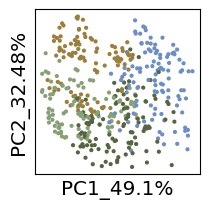

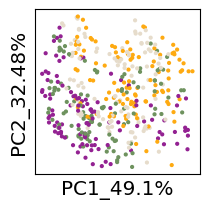

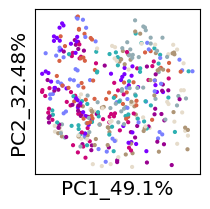

<IPython.core.display.Javascript object>

In [11]:
# Adjust the plotting order
Y_pca_df_wt_ctrl = Y_pca_df.loc[(Y_pca_df["culture"] == "WT_Ctrl-Ctrl")]
Y_pca_df_ak_ctrl = Y_pca_df.loc[Y_pca_df["culture"] == "AK_Ctrl-Ctrl"]
Y_pca_df_other = Y_pca_df.loc[
    -Y_pca_df["culture"].isin(["AK_Ctrl-Ctrl", "WT_Ctrl-Ctrl"])
]
Y_pca_df = pd.concat([Y_pca_df_other, Y_pca_df_ak_ctrl, Y_pca_df_wt_ctrl])

facets = ["genotype", "ligand", "inhibitor"]
for facet in facets:
    fig = scprep.plot.scatter2d(
        Y_pca_df.iloc[:, -2:],
        c=Y_pca_df.loc[:, facet],
        cmap=colours,
        ticks=False,
        xlabel=f"PC1_{pc1}%",
        ylabel=f"PC2_{pc2}%",
        s=4,
        legend=False,
        figsize=(2.2, 2.2),
    )


### CLU, LRIG1, Pan-CK, and SURVIVIN [S801/811]

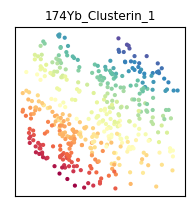

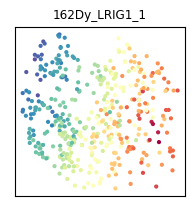

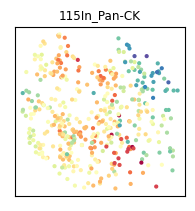

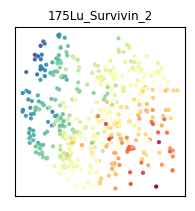

<IPython.core.display.Javascript object>

In [12]:
for marker in ["174Yb_Clusterin_1",  "162Dy_LRIG1_1", "115In_Pan-CK","175Lu_Survivin_2"]:
    fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.2))
    fig = scprep.plot.scatter2d(
        Y_pca_df.iloc[:, -2:],
        c=Y_pca_df.loc[:, marker],
        cmap=sns.color_palette("Spectral_r", as_cmap=True),
        ticks=False,
        s=4,
        xlabel="",
        ylabel="",
        legend=False,
        title=marker,
        fontsize=5,
        ax=ax,
    )

## EMD-PHATE Subset 

In [13]:
import os, sys
import pandas as pd
import numpy as np
import phate
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, "../..")
from scripts.aux_functions import *
from scripts import colours

from IPython.core.interactiveshell import InteractiveShell
%load_ext nb_black


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [14]:
# Import data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/Figure6_S6/Signal Perturbation"
input_dir = f"{base_dir}/output/emd"
output_dir = f"{base_dir}/output/"

# Set experimental metadata
subset = "all-cells"
norm = "no-norm" # no-norm
seed = 42

dr_panel = [
    # cell-type
    "111Cd_CD44",
    "113In_CEACAM1_CD66a",
    "115In_Pan-CK",
    # "116Cd_GFP",
    "143Nd_C-MYC_1",
    "162Dy_LRIG1_1",
    "169Tm_EPHB2",
    "171Yb_SOX9_5",
    "174Yb_Clusterin_1",
    "175Lu_Survivin_2",
    "176Yb_FABP2",
]


<IPython.core.display.Javascript object>

### Ctrl only (Figure S6A)

In [15]:
inhibitor = "Ctrl"

# Import data and get ready for PHATE
emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_{subset}_{norm}.csv")
emd_df_master_wide.head()
emd_df_master_wide_subset = emd_df_master_wide[
    (emd_df_master_wide["inhibitor"] == "Ctrl")
    | (emd_df_master_wide["inhibitor"] == inhibitor)
]
dr_matrix = master_df_subset(emd_df_master_wide_subset, dr_panel)

<IPython.core.display.Javascript object>

#### PHATE

(-0.22127928795487417,
 0.23440558289189867,
 -1.867226794794963e-05,
 2.054461776061657e-05)

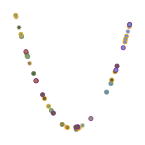

<IPython.core.display.Javascript object>

In [16]:
knn = 20
t = 15

phate_operator = phate.PHATE(
    knn=knn, t=t, random_state=seed, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide_subset = emd_df_master_wide_subset.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide_subset, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide_subset.drop(columns="index", inplace=True)

fig = scprep.plot.scatter2d(
    Y_phate_df.iloc[:, -2:],
    c=Y_phate_df.loc[:, "genotype"],
    edgecolors=Y_phate_df.loc[:, "ligand"].map(colours),
    linewidth=0.5,
    cmap=colours,
    ticks=False,
    s=9,
    label=None,
    legend=False,
    figsize=(1.8, 1.8),
    # alpha=0.8,
)
fig.axis("off")

##### CLU & LRIG1

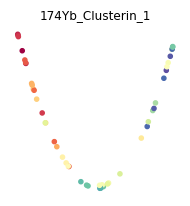

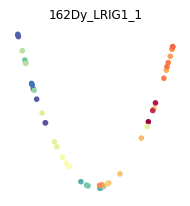

<IPython.core.display.Javascript object>

In [17]:
for marker in ["174Yb_Clusterin_1",  "162Dy_LRIG1_1"]:
    fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.2))
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, marker],
        cmap=sns.color_palette("Spectral_r", as_cmap=True),
        ticks=False,
        s=9,
        xlabel="",
        ylabel="",
        legend=False,
        title=marker,
        fontsize=5,
        ax=ax,
    )
    fig.axis("off")
    # plt.savefig(
    #     f"{output_dir}/EMD-PHATE_WNT-EGF-Gradient_{marker}.pdf",
    #     bbox_inches="tight",
    #     )

#### PCA

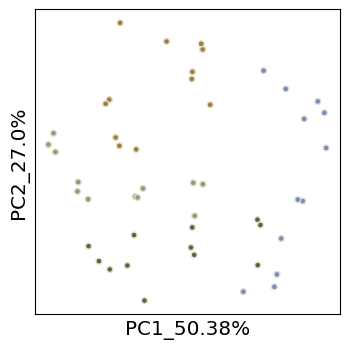

<IPython.core.display.Javascript object>

In [22]:
# ---
# PCA
# ---

pca = PCA(n_components=2)
pca.fit(dr_matrix)

Y_pca = pca.transform(dr_matrix)
pc1 = round(pca.explained_variance_ratio_[0] * 100, 2)  # %variance explained
pc2 = round(pca.explained_variance_ratio_[1] * 100, 2)

# Join PCA coordinates with EMD dataframe
Y_pca_df = pd.DataFrame(Y_pca).reset_index()
emd_df_master_wide = emd_df_master_wide.reset_index(drop=True).reset_index()
Y_pca_df = pd.merge(emd_df_master_wide, Y_pca_df, on="index")
Y_pca_df.drop(columns=["index"], inplace=True)
emd_df_master_wide.drop(columns="index", inplace=True)
Y_pca_df.head()

fig = scprep.plot.scatter2d(
    Y_pca_df.iloc[:, -2:],
    c=Y_pca_df.loc[:, "genotype"],
    edgecolors=Y_pca_df.loc[:, "ligand"].map(colours),
    cmap=colours,
    ticks=False,
    xlabel=f"PC1_{pc1}%",
    ylabel=f"PC2_{pc2}%",
    s=18,
    legend=False,
    figsize=(3.6, 3.6),
)   

##### CLU & LRIG1

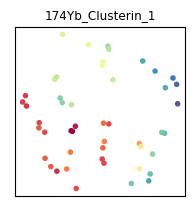

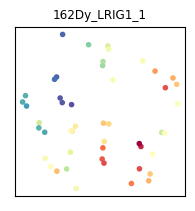

<IPython.core.display.Javascript object>

In [23]:
for marker in ["174Yb_Clusterin_1",  "162Dy_LRIG1_1"]:
    fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.2))
    fig = scprep.plot.scatter2d(
        Y_pca_df.iloc[:, -2:],
        c=Y_pca_df.loc[:, marker],
        cmap=sns.color_palette("Spectral_r", as_cmap=True),
        ticks=False,
        s=9,
        xlabel="",
        ylabel="",
        legend=False,
        title=marker,
        fontsize=5,
        ax=ax,
    )

## Obsolete analysis (Figure S6 in the first submission, removed after revision)

### GSK-3βi

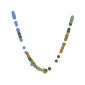

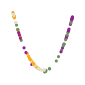

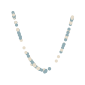

<IPython.core.display.Javascript object>

In [16]:
inhibitor = "CHIR99021"
knn = 20
t = 24

# Import data and get ready for PHATE
emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_{subset}_{norm}.csv")
emd_df_master_wide.head()
emd_df_master_wide_subset = emd_df_master_wide[
    (emd_df_master_wide["inhibitor"] == "Ctrl")
    | (emd_df_master_wide["inhibitor"] == inhibitor)
]
dr_matrix = master_df_subset(emd_df_master_wide_subset, dr_panel)

# PHATE
phate_operator = phate.PHATE(
    knn=knn, t=t, random_state=seed, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide_subset = emd_df_master_wide_subset.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide_subset, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide_subset.drop(columns="index", inplace=True)

# Plot
facets = ["genotype", "ligand", "inhibitor"]
for facet in facets:
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, facet],
        cmap=colours,
        ticks=False,
        s=1.5,
        label=None,
        legend=False,
        figsize=(1.2, 1.2),
    )
    fig.axis("off")


### β-CATi

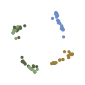

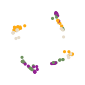

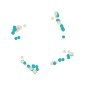

<IPython.core.display.Javascript object>

In [17]:
inhibitor = "ICG001"
knn = 8
t = 10

# Import data and get ready for PHATE
emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_{subset}_{norm}.csv")
emd_df_master_wide.head()
emd_df_master_wide_subset = emd_df_master_wide[
    (emd_df_master_wide["inhibitor"] == "Ctrl")
    | (emd_df_master_wide["inhibitor"] == inhibitor)
]
dr_matrix = master_df_subset(emd_df_master_wide_subset, dr_panel)

# PHATE
phate_operator = phate.PHATE(
    knn=knn, t=t, random_state=seed, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide_subset = emd_df_master_wide_subset.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide_subset, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide_subset.drop(columns="index", inplace=True)

# Plot
facets = ["genotype", "ligand", "inhibitor"]
for facet in facets:
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, facet],
        cmap=colours,
        ticks=False,
        s=1.5,
        label=None,
        legend=False,
        figsize=(1.2, 1.2),
    )
    fig.axis("off")


### SMAD3i

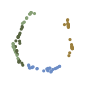

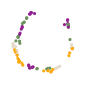

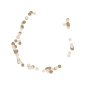

<IPython.core.display.Javascript object>

In [18]:
inhibitor = "SIS3"
knn = 10
t = 5

# Import data and get ready for PHATE
emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_{subset}_{norm}.csv")
emd_df_master_wide.head()
emd_df_master_wide_subset = emd_df_master_wide[
    (emd_df_master_wide["inhibitor"] == "Ctrl")
    | (emd_df_master_wide["inhibitor"] == inhibitor)
]
dr_matrix = master_df_subset(emd_df_master_wide_subset, dr_panel)

# PHATE
phate_operator = phate.PHATE(
    knn=knn, t=t, random_state=seed, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide_subset = emd_df_master_wide_subset.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide_subset, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide_subset.drop(columns="index", inplace=True)

# Plot
facets = ["genotype", "ligand", "inhibitor"]
for facet in facets:
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, facet],
        cmap=colours,
        ticks=False,
        s=1.5,
        label=None,
        legend=False,
        figsize=(1.2, 1.2),
    )
    fig.axis("off")


### YAPi

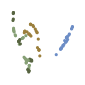

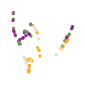

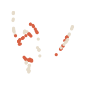

<IPython.core.display.Javascript object>

In [19]:
inhibitor = "CA3"
knn = 5
t = 15

# Import data and get ready for PHATE
emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_{subset}_{norm}.csv")
emd_df_master_wide.head()
emd_df_master_wide_subset = emd_df_master_wide[
    (emd_df_master_wide["inhibitor"] == "Ctrl")
    | (emd_df_master_wide["inhibitor"] == inhibitor)
]
dr_matrix = master_df_subset(emd_df_master_wide_subset, dr_panel)

# PHATE
phate_operator = phate.PHATE(
    knn=knn, t=t, random_state=seed, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide_subset = emd_df_master_wide_subset.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide_subset, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide_subset.drop(columns="index", inplace=True)

# Plot
facets = ["genotype", "ligand", "inhibitor"]
for facet in facets:
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, facet],
        cmap=colours,
        ticks=False,
        s=1.5,
        label=None,
        legend=False,
        figsize=(1.2, 1.2),
    )
    fig.axis("off")


### SRCi

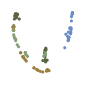

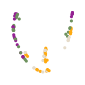

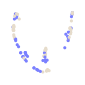

<IPython.core.display.Javascript object>

In [20]:
inhibitor = "Dasatinib"
knn = 6
t = 15

# Import data and get ready for PHATE
emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_{subset}_{norm}.csv")
emd_df_master_wide.head()
emd_df_master_wide_subset = emd_df_master_wide[
    (emd_df_master_wide["inhibitor"] == "Ctrl")
    | (emd_df_master_wide["inhibitor"] == inhibitor)
]
dr_matrix = master_df_subset(emd_df_master_wide_subset, dr_panel)

# PHATE
phate_operator = phate.PHATE(
    knn=knn, t=t, random_state=seed, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide_subset = emd_df_master_wide_subset.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide_subset, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide_subset.drop(columns="index", inplace=True)

# Plot
facets = ["genotype", "ligand", "inhibitor"]
for facet in facets:
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, facet],
        cmap=colours,
        ticks=False,
        s=1.5,
        label=None,
        legend=False,
        figsize=(1.2, 1.2),
    )
    fig.axis("off")


### PI3Ki

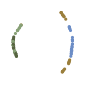

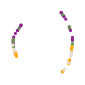

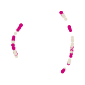

<IPython.core.display.Javascript object>

In [21]:
inhibitor = "GDC0941"
knn = 5
t = 15

# Import data and get ready for PHATE
emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_{subset}_{norm}.csv")
emd_df_master_wide.head()
emd_df_master_wide_subset = emd_df_master_wide[
    (emd_df_master_wide["inhibitor"] == "Ctrl")
    | (emd_df_master_wide["inhibitor"] == inhibitor)
]
dr_matrix = master_df_subset(emd_df_master_wide_subset, dr_panel)

# PHATE
phate_operator = phate.PHATE(
    knn=knn, t=t, random_state=seed, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide_subset = emd_df_master_wide_subset.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide_subset, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide_subset.drop(columns="index", inplace=True)

# Plot
facets = ["genotype", "ligand", "inhibitor"]
for facet in facets:
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, facet],
        cmap=colours,
        ticks=False,
        s=1.5,
        label=None,
        legend=False,
        figsize=(1.2, 1.2),
    )
    fig.axis("off")


### FAKi

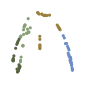

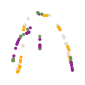

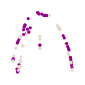

<IPython.core.display.Javascript object>

In [22]:
inhibitor = "PF573228"
knn = 5
t = 20

# Import data and get ready for PHATE
emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_{subset}_{norm}.csv")
emd_df_master_wide.head()
emd_df_master_wide_subset = emd_df_master_wide[
    (emd_df_master_wide["inhibitor"] == "Ctrl")
    | (emd_df_master_wide["inhibitor"] == inhibitor)
]
dr_matrix = master_df_subset(emd_df_master_wide_subset, dr_panel)

# PHATE
phate_operator = phate.PHATE(
    knn=knn, t=t, random_state=seed, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide_subset = emd_df_master_wide_subset.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide_subset, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide_subset.drop(columns="index", inplace=True)

# Plot
facets = ["genotype", "ligand", "inhibitor"]
for facet in facets:
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, facet],
        cmap=colours,
        ticks=False,
        s=1.5,
        label=None,
        legend=False,
        figsize=(1.2, 1.2),
    )
    fig.axis("off")


### MAPKi

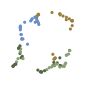

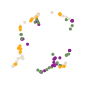

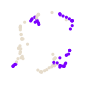

<IPython.core.display.Javascript object>

In [23]:
inhibitor = "Trametinib"
knn = 7
t = 15

# Import data and get ready for PHATE
emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_{subset}_{norm}.csv")
emd_df_master_wide.head()
emd_df_master_wide_subset = emd_df_master_wide[
    (emd_df_master_wide["inhibitor"] == "Ctrl")
    | (emd_df_master_wide["inhibitor"] == inhibitor)
]
dr_matrix = master_df_subset(emd_df_master_wide_subset, dr_panel)

# PHATE
phate_operator = phate.PHATE(
    knn=knn, t=t, random_state=seed, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide_subset = emd_df_master_wide_subset.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide_subset, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide_subset.drop(columns="index", inplace=True)

# Plot
facets = ["genotype", "ligand", "inhibitor"]
for facet in facets:
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, facet],
        cmap=colours,
        ticks=False,
        s=1.5,
        label=None,
        legend=False,
        figsize=(1.2, 1.2),
    )
    fig.axis("off")


# Relative Stemness Score Calculation

In [24]:
import os
import pandas as pd
import scprep
from scipy.stats import zscore
import numpy as np
import warnings

sys.path.insert(0, "../..")
from scripts.aux_functions import *

<IPython.core.display.Javascript object>

In [25]:
# Import data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/Figure5-S6/Signal Perturbation"
os.makedirs(f"{base_dir}/output/stem-score", exist_ok=True)
output_dir = f"{base_dir}/output/stem-score"

# NB: integrated dataframe can be accessed at <10.5281/zenodo.7586958>
input_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Data Share/CyTOFdataframes"

# ---
# Generate full_panel and metadata_columns on the fly
# ---

df = pd.read_csv(f"{input_dir}/Signal-Perturbation_all-cells.csv")
df_columns = df.columns.values.tolist()
column_filtered = list(
    filter(lambda x: x not in non_marker, df_columns)
)  # Exclude non-markers

full_panel = [i for i in column_filtered if i[0].isdigit()]
metadata_columns = list(filter(lambda x: x not in full_panel, column_filtered))

# Arcsinh transformation
df_arc = arcsinh_transf(df, full_panel, 5)
# Take forward CLU & LRIG1
markers = ["162Dy_LRIG1_1", "174Yb_Clusterin_1"]
df_arc_subset = df_arc.loc[:, metadata_columns + markers]


<IPython.core.display.Javascript object>

In [26]:
# Add column: pro_vs_rev, LRIG1/CLU
df_arc_subset["pro_vs_rev"] = (
    df_arc_subset["162Dy_LRIG1_1"] / df_arc_subset["174Yb_Clusterin_1"]
)

# * Log2 transformation, balanced ratio comparison
df_arc_subset["pro_vs_rev_log2"] = np.log2(df_arc_subset["pro_vs_rev"])
df_arc_subset.head()

# remove inf and -inf, then summarise
temp = pd.DataFrame(df_arc_subset["pro_vs_rev_log2"])
temp[~temp.isin([np.nan, np.inf, -np.inf]).any(1)].describe().apply(
    lambda s: s.apply("{0:.5f}".format)
)
np.quantile(temp[~temp.isin([np.nan, np.inf, -np.inf]).any(1)], 0.99, axis=0)  # 5.56
np.quantile(temp[~temp.isin([np.nan, np.inf, -np.inf]).any(1)], 0.01, axis=0)  # -3.18

# Remove outliers
df_arc_subset_outlier_removed = df_arc_subset[
    (df_arc_subset["pro_vs_rev_log2"] < 5) & (df_arc_subset["pro_vs_rev_log2"] > -5)
]

<IPython.core.display.Javascript object>

In [27]:
# ---
# *  Split by Condition
# ---

# Condition-based analysis, for heatmap in Figure S6C
df_arc_subset_outlier_removed_mean = df_arc_subset_outlier_removed.groupby(
    "condition"
).mean()
df_arc_subset_outlier_removed_mean.head()

for i in df_arc_subset_outlier_removed_mean.index.values:
    df_arc_subset_outlier_removed_mean.loc[i, "genotype"] = i.split("_")[1]
    df_arc_subset_outlier_removed_mean.loc[i, "culture"] = (
        i.split("_")[1] + "_" + i.split("_")[2]
    )
    df_arc_subset_outlier_removed_mean.loc[i, "ligand"] = i.split("_")[2].split("-")[0]
    df_arc_subset_outlier_removed_mean.loc[i, "inhibitor"] = i.split("_")[2].split("-")[
        1
    ]
    df_arc_subset_outlier_removed_mean.loc[i, "replicate"] = i.split("_")[3]
df_arc_subset_outlier_removed_mean.drop(columns=["barcode", "A", "K"], inplace=True)

df_arc_subset_outlier_removed_mean.to_csv(
    f"{output_dir}/stemness-score_log2_by-condition_raw.csv", index=False
)

# Culture-based analysis with standard deviation, for Figure 6F
# Calculate mean of log2([LRIG1]/[CLU]) across replicates
df_arc_subset_outlier_removed_mean_mean = df_arc_subset_outlier_removed_mean.groupby(
    "culture"
).mean()
df_arc_subset_outlier_removed_mean_mean.rename(
    columns={"pro_vs_rev_log2": "pvr_log2_mean"}, inplace=True
)
df_arc_subset_outlier_removed_mean_mean.head()

# Calculate std of log2([LRIG1]/[CLU]) across replicates
df_arc_subset_outlier_removed_mean_std = df_arc_subset_outlier_removed_mean.groupby(
    "culture"
).std()
df_arc_subset_outlier_removed_mean_std.rename(
    columns={"pro_vs_rev_log2": "pvr_log2_std"}, inplace=True
)
df_arc_subset_outlier_removed_mean_std.head()

# Concatenate dataframes
df_arc_subset_outlier_removed_mean_mean_std = pd.concat(
    [
        df_arc_subset_outlier_removed_mean_mean,
        df_arc_subset_outlier_removed_mean_std["pvr_log2_std"],
    ],
    axis=1,
)
df_arc_subset_outlier_removed_mean_mean_std.head()

# Update metadata columns
for i in df_arc_subset_outlier_removed_mean_mean_std.index.values:
    df_arc_subset_outlier_removed_mean_mean_std.loc[i, "genotype"] = i.split("_")[0]
    df_arc_subset_outlier_removed_mean_mean_std.loc[i, "culture"] = (
        i.split("_")[0] + "_" + i.split("_")[1]
    )
    df_arc_subset_outlier_removed_mean_mean_std.loc[i, "ligand"] = i.split("_")[
        1
    ].split("-")[0]
    df_arc_subset_outlier_removed_mean_mean_std.loc[i, "inhibitor"] = i.split("_")[
        1
    ].split("-")[1]
df_arc_subset_outlier_removed_mean_mean_std.head()

df_arc_subset_outlier_removed_mean_mean_std.to_csv(
    f"{output_dir}/stemness-score_log2_by-condition.csv", index=False
)

<IPython.core.display.Javascript object>